In [1]:
#
# This is the calculation of mathematical reserves for insurance on one life
# Pls consult first lecture notes
#
# It is based on annuity and capital. Hence for comments see there
# Incremental comments added
#


import math
import numpy as np

filename = "EK95.txt"
EKMF95 = np.loadtxt(filename, skiprows=0)

#print(EKMF95[20,:])

def QxEK95(gender,x,t,param =[]):
    return(EKMF95[x,gender+1])

def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxNoReduction(gender,x,t,param =[]):
    # This is our default mortality
    t = 2015
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))

def QxMedieval(gender,x,t,param =[]):
    a=-9.13275
    b= 8.09432e-2
    c= -1.1018e-5
    value=math.exp(a+(b+c*x)*x)
    alpha = 7.26502413
    beta = 0.01342065
    return(max(0,min(1,alpha*value+beta)))

def ConstantBenefit(x,param=[]):
    return(1.)

def ZeroBenefit(x,param=[]):
    return(0.)

def ExpBenefit(x,param=[]):
    x0 = param[0]
    alpha = param[1]
    return((1+alpha)**(x-x0))

def DeferredBenefit(x,param=[]):
    x0 = param[0]
    if x>= x0: return(1)
    return(0)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Capital:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymM = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = self.psymM(s,param=param)
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = qx * self.dV * self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px * qx * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
        
        n = s - x
        if n < periods:
            CF[n] = px * self.psymM(s,param=param)
            
        return(CF)
    


class Annuity:
    def __init__(self,Qx,i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit
        self.psymQx = Qx
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
        
    def CalcPV(self,gender,x,s,param=[]):
        PV = 0
        n  = s-x
        for i in range(s-1,x-1,-1):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            px = 1. - qx
            PV = self.psymB(i,param=param) + px * self.dV * PV
        return(PV)
    
    def CalcCF(self,gender,x,s,periods = 50,param=[]):
        CF = np.zeros(periods)
        px = 1
        for i in range(x,s):
            t = self.nT0 + i - x
            qx = self.psymQx(gender,i,t)
            n = i - x
            if n >= periods:
                break
            CF[n] = px  * self.psymB(i,param=param)
            px *= (1-qx)
            #print(i, px, qx)
            
        return(CF)
    
class DK:
    # This is the class dealing with mathematical reserves
    # What this actually does is reusing annuity and capital classes and combining them
    # As needed
    # Ultimately there is the PV of futire benefits (either capital or annuity), and
    # the PV of premium (this is an annuity)
    def __init__(self,Qx,strType, i=0.02,omega=110,t0 = 2020):
        self.dIrate = i
        self.nOmega = omega
        self.psymB = ConstantBenefit # Benefit Vector as a function
        self.psymM = ConstantBenefit # ...B for annuities and death benefit
        self.psymP = ConstantBenefit # ...M for maturity benefit and ...P for Premium
        self.dPrem = None # This is the place for the calulated premium None - not calculated
        self.psymQx = Qx # Out mortality table
        self.dV = 1. /(1+self.dIrate)
        self.nT0 = t0
        self.psymLeist = None # PV of benefit once calculated
        self.psymPraem = None
        self.nSL = None # End age Leistungs payment (benefit)
        self.nSP = None # End age Premium payment
        self.nGender = None
        self.strType = strType
        if self.strType == "A": # Set up of correct structure depending on used class
            self.strComment = "Annuity"
            self.psymLeist = Annuity(Qx,i=i,omega=omega,t0 = t0)
        else:
            self.strComment = "Capital"
            self.psymLeist = Capital(Qx,i=i,omega=omega,t0 = t0)
            
        self.psymPraem = Annuity(Qx,i=i,omega=omega,t0 = t0) # Premium are annuities
        print("Setting up Object for:", self.strComment)
        
        
    def CommFu(self,gender,x,symbol):
        # Allowable symbnols l, D, N, S, C, M, R
        if symbol == "l":
            l = 100000.
            px = 1.
            for i in range(x):
                t = self.nT0 + i
                qx = self.psymQx(gender,i,t) 
                px *= (1-qx)
            return(l * px)
        if symbol == "D":
            return(self.CommFu(gender,x,"l")*self.dV**x)
        if symbol == "C":
            return((self.CommFu(gender,x,"l")-self.CommFu(gender,x+1,"l"))*self.dV**(x+1))
        if symbol == "N":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"D")
            return(sum)
        if symbol == "S":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"N")
            return(sum)
        if symbol == "M":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"C")
            return(sum)
        if symbol == "R":
            sum = 0 
            for i in range(x,self.nOmega):
                sum += self.CommFu(gender,i,"M")
            return(sum)
        return("Error")
    
    def CalcPremium(self,gender,x,sL,sP,param=[]):
        self.nSL = sL
        self.nSP = sP
        self.nGender = gender
        self.psymLeist.psymB = self.psymB
        self.psymLeist.psymM = self.psymM
        self.psymPraem.psymB = self.psymP
        # Equivalence Principle Prem = PV_Benefits/PV_Premium at inception
        self.dPrem = self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param)/self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param)
        print(self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param),self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param))
        print("Premium =",self.dPrem)
    
    def CalcPV(self,x,param=[]): 
        # PV Future Benefits - PV Future Premium
        PVL = self.psymLeist.CalcPV(self.nGender,x,self.nSL,param=param)
        PVP = self.psymPraem.CalcPV(self.nGender,x,self.nSP,param=param) * self.dPrem
        PV = PVL - PVP
        return([PVL, PVP, PV])
    
    def CalcSavingRiskPreium(self,x,param=[]):
        # This is new - decmposition into savings and risk premium
        a = self.CalcPV(x,param=param)
        b = self.CalcPV(x+1,param=param)
        MR_T_1 = b[2] 
        MR_T = a[2]
        v = self.dV
        qx = self.psymQx(self.nGender,x,self.nT0) # Please adjust
        DeathBenefit = 0 # Please adjust
        if self.strType != "A":
            DeathBenefit = self.psymB(x,param=param)
        SP = MR_T_1 * v - MR_T
        RP = (DeathBenefit - MR_T_1) * v * qx
        return([SP,RP])
    
    def CalcCF(self,x,periods = 50,param=[]):
        CFL = self.psymLeist.CalcCF(self.nGender,x,self.nSL,periods = periods, param=param)
        CFP = -self.dPrem * self.psymPraem.CalcCF(self.nGender,x,self.nSP,periods = periods, param=param)
        CF  = CFL + CFP
        return([CFL,CFP,CF])

Setting up Object for: Capital


Current Age (40)  26
End Premium Payment age (65)  65
End Benefit age (65)  65
Gender (0 ==> m male, 1 ==> female)  0


0.46970632056672795 27.044977651096822
Premium = 0.01736759876921839


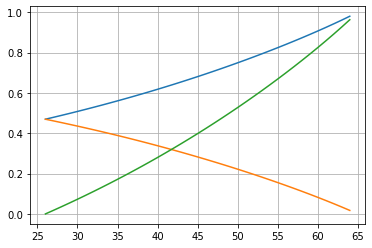

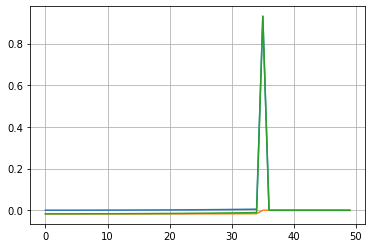

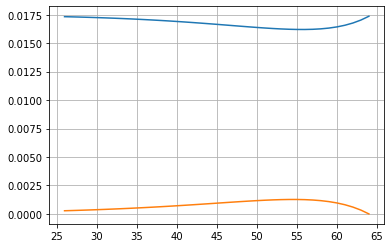

In [4]:
test = DK(Qx, "C")
x  = int(input("Current Age (40) ")) 
x0=x
sP = int(input("End Premium Payment age (65) "))
sL = int(input("End Benefit age (65) "))
gender = int(input("Gender (0 ==> m male, 1 ==> female) "))
test.CalcPremium(gender,x,sL,sP)
x=[]
y=[]
zr =[]
zs =[]
for i in range(x0,max(sP,sL)):
    x.append(i)
    y.append(test.CalcPV(i))
    w = test.CalcSavingRiskPreium(i)
    zs.append(w[0])
    zr.append(w[1])
    
plt.figure(1)
plt.plot(x,y)
plt.grid(True)
CF=test.CalcCF(30)
plt.figure(2)
plt.plot(range(50),CF[0],range(50),CF[1],range(50),CF[2])
plt.grid(True)

plt.figure(3)
plt.plot(x,zs,x,zr)
plt.grid(True)

Setting up Object for: Annuity


Current Age (40)  40
End Premium Payment age (65)  60
Start Benefit age (65)  65
Gender (0 ==> m male, 1 ==> female)  0


11.222440870170857 16.42439741340305
Premium = 0.6832786973976189


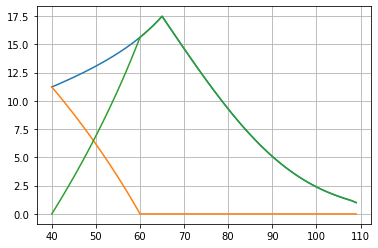

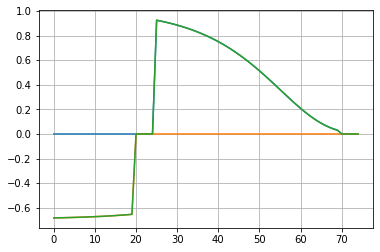

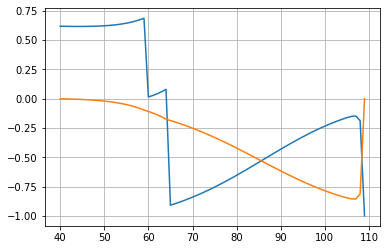

In [6]:
test2=DK(Qx, "A") #{}_n ae _ x financed with ae_{n:n}
test2.psymB = DeferredBenefit
x  = int(input("Current Age (40) ")) 
sP = int(input("End Premium Payment age (65) "))
sL = int(input("Start Benefit age (65) "))
gender = int(input("Gender (0 ==> m male, 1 ==> female) "))
test2.CalcPremium(gender,x,110,sP,param=[sL])
xx=[]
y=[]
zs=[]
zr=[]
for i in range(x,110):
    xx.append(i)
    y.append(test2.CalcPV(i,param=[sL]))
    w = test2.CalcSavingRiskPreium(i,param=[sL])
    zs.append(w[0])
    zr.append(w[1])
plt.figure(2)
plt.plot(xx,y)
plt.grid(True)
CF=test2.CalcCF(x,periods=75,param=[sL])
plt.figure(3)
plt.plot(range(75),CF[0],range(75),CF[1],range(75),CF[2])
plt.grid(True)
plt.figure(4)
plt.plot(xx,zs,xx,zr)
plt.grid(True)

Setting up Object for: Annuity
9.697936161414237 25.07776311974728
Premium = 0.38671456122726017
How calculate savings and risk premium


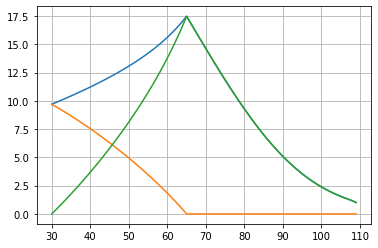

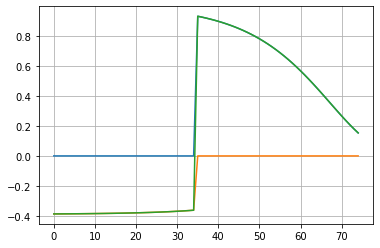

In [7]:
test2=DK(Qx, "A")
test2.psymB = DeferredBenefit
x  = 30
sP = 65
sL = 65
gender = 0
test2.CalcPremium(gender,x,110,sP,param=[sL])
xx=[]
y=[]
zr =[]
zs =[]
for i in range(x,110):
    xx.append(i)
    y.append(test2.CalcPV(i,param=[sL]))
plt.figure(2)
plt.plot(xx,y)
plt.grid(True)
CF=test2.CalcCF(x,periods=75,param=[sL])
plt.figure(3)
plt.plot(range(75),CF[0],range(75),CF[1],range(75),CF[2])
plt.grid(True)

print("How calculate savings and risk premium")